DATA AUGMENTATION
Techniques:
- Back-Translation (EN→FR→EN, EN→ES→EN)
- Synonym Replacement
- Random Insertion
- Random Swap
- Random Deletion

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
from nltk.corpus import wordnet

# Télécharger les données NLTK nécessaires
try:
    nltk.data.find('corpora/wordnet')
except:
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('averaged_perceptron_tagger')

print("✅ Bibliothèques importées")

random.seed(42)
np.random.seed(42)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayoub\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ayoub\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ayoub\AppData\Roaming\nltk_data...


✅ Bibliothèques importées


[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


 CHARGEMENT DES DONNÉES & SPLIT

In [3]:
print("\n" + "="*70)
print("CHARGEMENT DES DONNÉES")
print("="*70)

# Charger les données nettoyées
df = pd.read_csv('DataSet/spam_cleaned.csv')

print(f" Données chargées:")
print(f"  - Total: {len(df)} messages")
print(f"  - Ham: {len(df[df['label']=='ham'])} ({len(df[df['label']=='ham'])/len(df)*100:.1f}%)")
print(f"  - Spam: {len(df[df['label']=='spam'])} ({len(df[df['label']=='spam'])/len(df)*100:.1f}%)")



CHARGEMENT DES DONNÉES
 Données chargées:
  - Total: 5169 messages
  - Ham: 4516 (87.4%)
  - Spam: 653 (12.6%)


IMPORTANT: SPLIT AVANT L'AUGMENTATION!

In [4]:
print("\n" + "="*70)
print("  SPLIT AVANT AUGMENTATION (Éviter Data Leakage!)")
print("="*70)

from sklearn.model_selection import train_test_split

# Séparer features et labels
X = df['message'].values
y = df['label'].values

# Split: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f" Split effectué:")
print(f"  - Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Val: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  - Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Créer DataFrames pour train/val/test
train_df = pd.DataFrame({'message': X_train, 'label': y_train})
val_df = pd.DataFrame({'message': X_val, 'label': y_val})
test_df = pd.DataFrame({'message': X_test, 'label': y_test})

#  ON AUGMENTE SEULEMENT LE TRAIN SET!
spam_train_df = train_df[train_df['label'] == 'spam'].copy()
ham_train_df = train_df[train_df['label'] == 'ham'].copy()

print(f"\n Distribution TRAIN SET:")
print(f"  - Ham: {len(ham_train_df)}")
print(f"  - Spam: {len(spam_train_df)}")
print(f"  - Ratio: {len(ham_train_df)/len(spam_train_df):.2f}:1")

# Objectif: équilibrer le TRAIN SET uniquement
target_spam_count = len(ham_train_df)
needed_spam = target_spam_count - len(spam_train_df)

print(f"\n OBJECTIF (Train set uniquement):")
print(f"  - Spam actuels (train): {len(spam_train_df)}")
print(f"  - Spam cibles (train): {target_spam_count}")
print(f"  - Spam à générer: {needed_spam}")

print(f"\n Val et Test sets restent INTACTS (pas d'augmentation):")



  SPLIT AVANT AUGMENTATION (Éviter Data Leakage!)
 Split effectué:
  - Train: 3618 (70.0%)
  - Val: 775 (15.0%)
  - Test: 776 (15.0%)

 Distribution TRAIN SET:
  - Ham: 3161
  - Spam: 457
  - Ratio: 6.92:1

 OBJECTIF (Train set uniquement):
  - Spam actuels (train): 457
  - Spam cibles (train): 3161
  - Spam à générer: 2704

 Val et Test sets restent INTACTS (pas d'augmentation):


TECHNIQUE 1: BACK-TRANSLATION

In [5]:
print("\n" + "="*70)
print("TECHNIQUE 1: BACK-TRANSLATION (EN→FR→EN)")
print("="*70)

try:
    from transformers import MarianMTModel, MarianTokenizer
    
    print("Chargement des modèles de traduction...")
    
    # Modèle EN→FR
    model_en_fr = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-en-fr')
    tokenizer_en_fr = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-en-fr')
    
    # Modèle FR→EN
    model_fr_en = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-fr-en')
    tokenizer_fr_en = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-fr-en')
    
    print("✅ Modèles chargés!")
    
    def back_translate_fr(text):
        """Back-translation EN→FR→EN"""
        try:
            # EN → FR
            inputs = tokenizer_en_fr(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            translated = model_en_fr.generate(**inputs, max_length=512)
            fr_text = tokenizer_en_fr.decode(translated[0], skip_special_tokens=True)
            
            # FR → EN
            inputs = tokenizer_fr_en(fr_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            back_translated = model_fr_en.generate(**inputs, max_length=512)
            en_text = tokenizer_fr_en.decode(back_translated[0], skip_special_tokens=True)
            
            return en_text
        except Exception as e:
            print(f"Erreur back-translation: {e}")
            return text
    
    # Test
    test_msg = spam_df.iloc[0]['message']
    print(f"\n Test Back-Translation:")
    print(f"Original: {test_msg}")
    augmented = back_translate_fr(test_msg)
    print(f"Augmented: {augmented}")
    
    BACK_TRANSLATION_AVAILABLE = True
    
except ImportError:
    print("⚠️  Transformers non installé. Back-translation désactivée.")
    print("   Pour activer: pip install transformers")
    BACK_TRANSLATION_AVAILABLE = False
    
    def back_translate_fr(text):
        return text


TECHNIQUE 1: BACK-TRANSLATION (EN→FR→EN)
Chargement des modèles de traduction...


config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

⚠️  Transformers non installé. Back-translation désactivée.
   Pour activer: pip install transformers


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

TECHNIQUE 2: SYNONYM REPLACEMENT

In [7]:
print("\n" + "="*70)
print("TECHNIQUE 2: SYNONYM REPLACEMENT")
print("="*70)

def get_synonyms(word):
    """Récupère les synonymes d'un mot via WordNet"""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').replace('-', ' ').lower()
            if synonym != word.lower() and ' ' not in synonym:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(text, n=2):
    """Remplace n mots par des synonymes aléatoires"""
    words = text.split()
    new_words = words.copy()
    
    # Mots candidats (alphanumériques uniquement)
    random_word_list = [word for word in words if word.isalnum() and len(word) > 3]
    random.shuffle(random_word_list)
    
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    
    return ' '.join(new_words)




TECHNIQUE 2: SYNONYM REPLACEMENT


TECHNIQUE 3: RANDOM INSERTION

In [9]:
print("\n" + "="*70)
print("TECHNIQUE 3: RANDOM INSERTION")
print("="*70)

def random_insertion(text, n=1):
    """Insère n synonymes aléatoires dans le texte"""
    words = text.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
    
    return ' '.join(new_words)

def add_word(words):
    """Ajoute un synonyme aléatoire à une position aléatoire"""
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        if len(words) == 0:
            return
        random_word = words[random.randint(0, len(words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:  # Éviter boucle infinie
            return
    
    random_synonym = random.choice(synonyms)
    random_idx = random.randint(0, len(words))
    words.insert(random_idx, random_synonym)




TECHNIQUE 3: RANDOM INSERTION


TECHNIQUE 4: RANDOM SWAP

In [10]:
print("\n" + "="*70)
print("TECHNIQUE 4: RANDOM SWAP")
print("="*70)

def random_swap(text, n=1):
    """Échange la position de n paires de mots"""
    words = text.split()
    new_words = words.copy()
    
    for _ in range(n):
        new_words = swap_word(new_words)
    
    return ' '.join(new_words)

def swap_word(words):
    """Échange deux mots aléatoires"""
    if len(words) < 2:
        return words
    
    random_idx_1 = random.randint(0, len(words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(words)-1)
        counter += 1
        if counter > 3:
            return words
    
    words[random_idx_1], words[random_idx_2] = words[random_idx_2], words[random_idx_1]
    return words




TECHNIQUE 4: RANDOM SWAP


TECHNIQUE 5: RANDOM DELETION

In [11]:
print("\n" + "="*70)
print("TECHNIQUE 5: RANDOM DELETION")
print("="*70)

def random_deletion(text, p=0.2):
    """Supprime chaque mot avec probabilité p"""
    words = text.split()
    
    # Ne pas supprimer si un seul mot
    if len(words) == 1:
        return text
    
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    
    # Si tous supprimés, garder un mot aléatoire
    if len(new_words) == 0:
        return random.choice(words)
    
    return ' '.join(new_words)




TECHNIQUE 5: RANDOM DELETION


FONCTION D'AUGMENTATION PRINCIPALE

In [12]:
print("\n" + "="*70)
print("GÉNÉRATION DES DONNÉES AUGMENTÉES")
print("="*70)

def augment_text(text, technique):
    """Applique une technique d'augmentation à un texte"""
    try:
        if technique == 'back_translation' and BACK_TRANSLATION_AVAILABLE:
            return back_translate_fr(text)
        elif technique == 'synonym_replacement':
            return synonym_replacement(text, n=random.randint(1, 3))
        elif technique == 'random_insertion':
            return random_insertion(text, n=1)
        elif technique == 'random_swap':
            return random_swap(text, n=random.randint(1, 2))
        elif technique == 'random_deletion':
            return random_deletion(text, p=0.2)
        else:
            return text
    except Exception as e:
        print(f"Erreur augmentation: {e}")
        return text

# Distribution des techniques
if BACK_TRANSLATION_AVAILABLE:
    techniques = ['back_translation', 'synonym_replacement', 'random_insertion', 
                  'random_swap', 'random_deletion']
    weights = [0.3, 0.3, 0.2, 0.1, 0.1]
else:
    techniques = ['synonym_replacement', 'random_insertion', 'random_swap', 'random_deletion']
    weights = [0.4, 0.3, 0.2, 0.1]

print(f"Techniques disponibles: {techniques}")
print(f"Poids: {weights}")

# Générer les messages augmentés
augmented_messages = []
augmented_labels = []

print(f"\nGénération de {needed_spam} messages augmentés (train set uniquement)...")

spam_messages = spam_train_df['message'].tolist()  # ← Seulement train spam!

# Calculer combien d'augmentations par message original
augmentations_per_message = (needed_spam // len(spam_messages)) + 1

from tqdm import tqdm

for i, msg in enumerate(tqdm(spam_messages, desc="Augmentation")):
    # Garder l'original
    augmented_messages.append(msg)
    augmented_labels.append('spam')
    
    # Générer des augmentations
    for _ in range(augmentations_per_message):
        if len(augmented_messages) >= len(spam_messages) + needed_spam:
            break
        
        # Choisir une technique aléatoire
        technique = random.choices(techniques, weights=weights)[0]
        
        # Appliquer l'augmentation
        aug_msg = augment_text(msg, technique)
        
        # Vérifier que c'est différent de l'original
        if aug_msg != msg and len(aug_msg) > 5:
            augmented_messages.append(aug_msg)
            augmented_labels.append('spam')

print(f"\n✅ Augmentation terminée!")
print(f"  - Messages générés: {len(augmented_messages)}")
print(f"  - Originaux: {len(spam_messages)}")
print(f"  - Nouveaux: {len(augmented_messages) - len(spam_messages)}")


GÉNÉRATION DES DONNÉES AUGMENTÉES
Techniques disponibles: ['synonym_replacement', 'random_insertion', 'random_swap', 'random_deletion']
Poids: [0.4, 0.3, 0.2, 0.1]

Génération de 2704 messages augmentés (train set uniquement)...


Augmentation: 100%|██████████| 457/457 [00:14<00:00, 31.62it/s] 


✅ Augmentation terminée!
  - Messages générés: 3163
  - Originaux: 457
  - Nouveaux: 2706


CRÉER LE NOUVEAU TRAIN SET ÉQUILIBRÉ

In [13]:
print("\n" + "="*70)
print("CRÉATION DU TRAIN SET ÉQUILIBRÉ")
print("="*70)

# Créer DataFrame avec spam augmentés (train uniquement)
augmented_spam_train_df = pd.DataFrame({
    'label': augmented_labels,
    'message': augmented_messages
})

# Limiter au nombre cible
augmented_spam_train_df = augmented_spam_train_df.iloc[:target_spam_count]

# Combiner avec ham du train set
balanced_train_df = pd.concat([ham_train_df[['label', 'message']], augmented_spam_train_df], ignore_index=True)

# Mélanger
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ Train set équilibré créé:")
print(f"  - Total: {len(balanced_train_df)} messages")
print(f"  - Ham: {len(balanced_train_df[balanced_train_df['label']=='ham'])}")
print(f"  - Spam: {len(balanced_train_df[balanced_train_df['label']=='spam'])}")
print(f"  - Nouveau ratio: {len(balanced_train_df[balanced_train_df['label']=='ham']) / len(balanced_train_df[balanced_train_df['label']=='spam']):.2f}:1")

print(f"\n⚠️  Val et Test sets restent ORIGINAUX (pas d'augmentation):")
print(f"  - Val: {len(val_df)} messages (Ham: {len(val_df[val_df['label']=='ham'])}, Spam: {len(val_df[val_df['label']=='spam'])})")
print(f"  - Test: {len(test_df)} messages (Ham: {len(test_df[test_df['label']=='ham'])}, Spam: {len(test_df[test_df['label']=='spam'])})")


CRÉATION DU TRAIN SET ÉQUILIBRÉ
✅ Train set équilibré créé:
  - Total: 6322 messages
  - Ham: 3161
  - Spam: 3161
  - Nouveau ratio: 1.00:1

⚠️  Val et Test sets restent ORIGINAUX (pas d'augmentation):
  - Val: 775 messages (Ham: 677, Spam: 98)
  - Test: 776 messages (Ham: 678, Spam: 98)


VISUALISATIONS


VISUALISATIONS


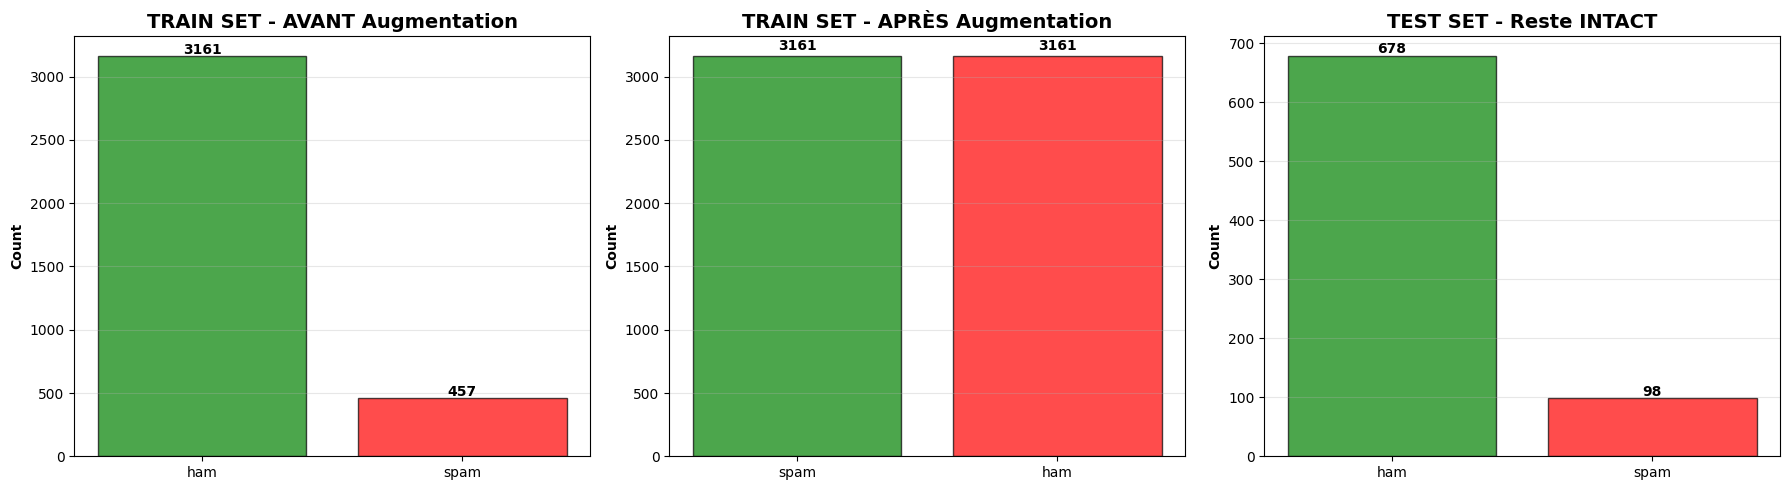

In [14]:
print("\n" + "="*70)
print("VISUALISATIONS")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# AVANT augmentation (train original)
train_orig_counts = train_df['label'].value_counts()
axes[0].bar(train_orig_counts.index, train_orig_counts.values, color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].set_title('TRAIN SET - AVANT Augmentation', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(train_orig_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# APRÈS augmentation (train augmenté)
balanced_counts = balanced_train_df['label'].value_counts()
axes[1].bar(balanced_counts.index, balanced_counts.values, color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title('TRAIN SET - APRÈS Augmentation', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(balanced_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Val/Test (restent intacts)
test_counts = test_df['label'].value_counts()
axes[2].bar(test_counts.index, test_counts.values, color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Count', fontweight='bold')
axes[2].set_title('TEST SET - Reste INTACT', fontweight='bold', fontsize=14)
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(test_counts.values):
    axes[2].text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('results/data_augmentation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

EXEMPLES D'AUGMENTATION

In [15]:
print("\n" + "="*70)
print("EXEMPLES D'AUGMENTATION")
print("="*70)

# Afficher quelques exemples
print("\n" + "-"*70)
for i in range(min(5, len(spam_train_df))):
    original = spam_train_df.iloc[i]['message']
    
    print(f"\n[Exemple {i+1}]")
    print(f"Original: {original}")
    
    # Générer avec chaque technique
    for technique in techniques:
        aug = augment_text(original, technique)
        if aug != original:
            print(f"{technique}: {aug}")

print("-"*70)


EXEMPLES D'AUGMENTATION

----------------------------------------------------------------------

[Exemple 1]
Original: This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate 
synonym_replacement: This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, holler 08718726970 NOW! Only 10p per min. BT-national-rate
random_insertion: This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate clip
random_swap: This is the 2nd time we have tried 2 contact u. Only per won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! U 10p have min. BT-national-rate
random_deletion: is time we tried 2 u. have won 750 Pound prize. 2 claim easy, 10p min.

[Exemple 2]
Original: Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly d

STATISTIQUES D'AUGMENTATION


STATISTIQUES D'AUGMENTATION

Longueur des messages (caractères):
  Original - Moyenne: 138.4, Médiane: 149.0
  Augmenté - Moyenne: 139.7, Médiane: 149.0


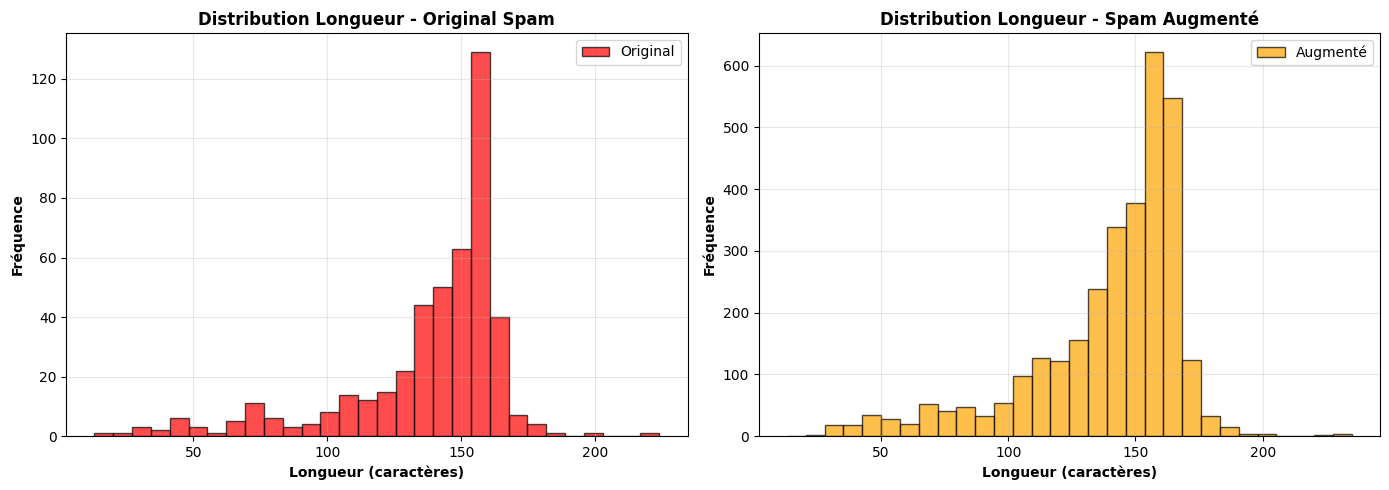

In [16]:
print("\n" + "="*70)
print("STATISTIQUES D'AUGMENTATION")
print("="*70)

# Analyser la longueur des messages
original_lengths = spam_train_df['message'].apply(len)
augmented_lengths = augmented_spam_train_df['message'].apply(len)

print(f"\nLongueur des messages (caractères):")
print(f"  Original - Moyenne: {original_lengths.mean():.1f}, Médiane: {original_lengths.median():.1f}")
print(f"  Augmenté - Moyenne: {augmented_lengths.mean():.1f}, Médiane: {augmented_lengths.median():.1f}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(original_lengths, bins=30, color='red', alpha=0.7, label='Original', edgecolor='black')
axes[0].set_xlabel('Longueur (caractères)', fontweight='bold')
axes[0].set_ylabel('Fréquence', fontweight='bold')
axes[0].set_title('Distribution Longueur - Original Spam', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(augmented_lengths, bins=30, color='orange', alpha=0.7, label='Augmenté', edgecolor='black')
axes[1].set_xlabel('Longueur (caractères)', fontweight='bold')
axes[1].set_ylabel('Fréquence', fontweight='bold')
axes[1].set_title('Distribution Longueur - Spam Augmenté', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/augmentation_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

SAUVEGARDER LES DATASETS

In [18]:

print("\n" + "="*70)
print("SAUVEGARDE DES DATASETS")
print("="*70)

# Sauvegarder le train set équilibré
balanced_train_df.to_csv('DataSet/train_augmented.csv', index=False)
print("✅ Train augmenté sauvegardé: 'DataSet/train_augmented.csv'")

# Sauvegarder le train set original
train_df.to_csv('DataSet/train_original.csv', index=False)
print("✅ Train original sauvegardé: 'DataSet/train_original.csv'")
# Sauvegarder val et test (INTACTS)
val_df.to_csv('DataSet/val.csv', index=False)
test_df.to_csv('DataSet/test.csv', index=False)
print("✅ Val set sauvegardé: 'DataSet/val.csv'")
print("✅ Test set sauvegardé: 'DataSet/test.csv'")

# Sauvegarder aussi les spam augmentés uniquement
augmented_spam_train_df.to_csv('DataSet/spam_augmented_only.csv', index=False)
print("✅ Spam augmentés sauvegardés: 'DataSet/spam_augmented_only.csv'")

# Statistiques
stats = {
    'original_train_total': len(train_df),
    'original_train_ham': len(ham_train_df),
    'original_train_spam': len(spam_train_df),
    'augmented_train_total': len(balanced_train_df),
    'augmented_train_ham': len(balanced_train_df[balanced_train_df['label']=='ham']),
    'augmented_train_spam': len(balanced_train_df[balanced_train_df['label']=='spam']),
    'val_total': len(val_df),
    'val_ham': len(val_df[val_df['label']=='ham']),
    'val_spam': len(val_df[val_df['label']=='spam']),
    'test_total': len(test_df),
    'test_ham': len(test_df[test_df['label']=='ham']),
    'test_spam': len(test_df[test_df['label']=='spam']),
    'new_spam_generated': len(augmented_messages) - len(spam_messages),
    'techniques_used': techniques
}

import json
with open('results/augmentation_stats.json', 'w') as f:
    json.dump(stats, f, indent=4)

print("✅ Statistiques sauvegardées: 'results/augmentation_stats.json'")


SAUVEGARDE DES DATASETS
✅ Train augmenté sauvegardé: 'DataSet/train_augmented.csv'
✅ Train original sauvegardé: 'DataSet/train_original.csv'
✅ Val set sauvegardé: 'DataSet/val.csv'
✅ Test set sauvegardé: 'DataSet/test.csv'
✅ Spam augmentés sauvegardés: 'DataSet/spam_augmented_only.csv'
✅ Statistiques sauvegardées: 'results/augmentation_stats.json'
